In [1]:
# Import dependencies
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read in the cardiovascular dataset from Google Sheets
cvd_df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSDchXr1EhgCSsxlxJ3lWPhh1kT5EJS3yv4DJ2YLeMIC3y4uq-Pp4EQknrs9zAiaI3ulne2Jyi6gR6G/pub?gid=602879552&single=true&output=csv")
cvd_df.head()

,general_health,checkup,exercise,heart_disease,skin_cancer,other_cancer,depression,diabetes,arthritis,sex,age_category,height_cm,weight_kg,bmi,smoking_history,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150,32.66,14.54,Yes,0,30,16,12
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165,77.11,28.29,No,0,30,0,4
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163,88.45,33.47,No,4,12,3,16
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180,93.44,28.73,No,0,30,30,8
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191,88.45,24.37,Yes,0,8,4,0


# Data Preprocessing

In [3]:
# Check datatypes
cvd_df.dtypes

general_health                   object
checkup                          object
exercise                         object
heart_disease                    object
skin_cancer                      object
other_cancer                     object
depression                       object
diabetes                         object
arthritis                        object
sex                              object
age_category                     object
height_cm                         int64
weight_kg                       float64
bmi                             float64
smoking_history                  object
alcohol_consumption               int64
fruit_consumption                 int64
green_vegetables_consumption      int64
friedpotato_consumption           int64
dtype: object

In [4]:
# Define categorical columns for encoding and numeric columns for scaling
categorical_cols = cvd_df.dtypes[cvd_df.dtypes == 'object'].index.tolist()

numeric_cols = cvd_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [5]:
# Check value counts of target variable
cvd_df['heart_disease'].value_counts()

No     275231
Yes     24081
Name: heart_disease, dtype: int64

The proportion of positive instances of heart disease ('Yes') to negative instances ('No') is heavily imbalanced. Initial testing revealed that this would result in a model that can accurately predict if a patient does not have heart diease, but is not able to accurately predict if a person does have disease. For this reason, we have decided to cut down the majority class, in this instance the 'No' category, to make the classes more balanced.

We have chosen to remove all datapoints that lay outside of 1 standard deviation from the mean of the data.

In [6]:
# Calculate mean and standard deviation for numeric columns
means = cvd_df[numeric_cols].mean()
stds = cvd_df[numeric_cols].std()

# Define the number of standard deviations for the threshold
threshold_std = 1

# Identify outliers for numeric columns based on standard deviations
outliers = ((cvd_df[numeric_cols] - means).abs() > threshold_std * stds).any(axis=1)

# Filter rows where 'heart_disease' is 'No' and not an outlier
filtered_rows = (~outliers) | (cvd_df['heart_disease'] == 'Yes')

# Create the filtered DataFrame
cvd_df_filtered = cvd_df[filtered_rows]

In [7]:
# Re-check value counts of target variable
cvd_df_filtered['heart_disease'].value_counts()

No     55566
Yes    24081
Name: heart_disease, dtype: int64

The classes in the target variable are now significantly closer to being balanced than previously.

In [8]:
# Encode categorical columns using get_dummies
encoded_df = pd.get_dummies(cvd_df_filtered, columns=categorical_cols, drop_first=False)
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,165,77.11,28.29,0,30,0,4,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,180,93.44,28.73,0,30,30,8,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,175,69.85,22.74,0,16,8,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,163,72.57,27.46,0,12,12,4,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,163,91.63,34.67,0,12,12,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [9]:
# Scale numerical columns using StandardScaler
scaler = StandardScaler()
encoded_df[numeric_cols] = scaler.fit_transform(encoded_df[numeric_cols])
encoded_df.head()

,height_cm,weight_kg,bmi,alcohol_consumption,fruit_consumption,green_vegetables_consumption,friedpotato_consumption,general_health_Excellent,general_health_Fair,general_health_Good,...,age_category_45-49,age_category_50-54,age_category_55-59,age_category_60-64,age_category_65-69,age_category_70-74,age_category_75-79,age_category_80+,smoking_history_No,smoking_history_Yes
1,-0.832260,-0.393566,-0.000590,-0.556508,0.413674,-1.250370,-0.166917,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,1.184427,0.704890,0.095604,-0.556508,0.413674,1.515171,0.547281,0,0,0,...,0,0,0,0,0,0,1,0,1,0
6,0.512198,-0.881918,-1.213951,-0.556508,-0.472114,-0.512893,-0.881115,0,1,0,...,0,0,0,1,0,0,0,0,0,1
8,-1.101152,-0.698954,-0.182048,-0.556508,-0.725196,-0.144154,-0.166917,0,1,0,...,0,0,0,0,1,0,0,0,0,1
9,-1.101152,0.583139,1.394228,-0.556508,-0.725196,-0.144154,-0.702566,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [10]:
# Assign the target variable 'heart_disease' to y
y = encoded_df['heart_disease_Yes']

# Assign the remaining columns (features) to X
X = encoded_df.drop(columns=['heart_disease_Yes', 'heart_disease_No'])

In [11]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [12]:
# Checking the value counts of the y variable
y_train.value_counts()

0    41653
1    18082
Name: heart_disease_Yes, dtype: int64

In [13]:
# Fit a random over sampler model to the training data to balance out the classes fully
ROS = RandomOverSampler(random_state=78)
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train)

In [14]:
# Re-check the value counts to ensure oversampling has worked
y_train_resampled.value_counts()

1    41653
0    41653
Name: heart_disease_Yes, dtype: int64

# Model 1: Logistic Regression

# Model 2: Support Vector Machine

# Model 3: Decision Tree

**The Decision Tree Classifier** is a machine learning algorithm that creates a tree-like structure to make decisions based on input features.
Each node in the tree represents a decision point based on a specific feature and a threshold value.
The tree branches out into two or more child nodes based on the feature values, creating a hierarchical structure.
The leaf nodes of the tree represent the predicted class labels.

It is known **simplicity and interpretability** and it is used for both classification and regression tasks.

In [15]:
# Import additional depedencies

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

**Model Creation**: In the code below, a Decision Tree Classifier is created with random_state=42. The random_state parameter ensures that the model's behavior remains consistent across runs for reproducibility.

In [16]:
# Creating Decision Tree Classifier

clf = DecisionTreeClassifier(random_state=42)

**Model Training**: The model is trained using the training data (X_train_resampled and y_train_resampled) with the fit method. During training, the Decision Tree algorithm learns to make decisions by selecting the best features and thresholds that result in the most accurate predictions on the training data.

In [17]:
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

**Making Predictions**: After training, the model is used to make predictions on the test dataset (X_test) with the predict method. The predicted labels are stored in the y_pred variable

In [18]:
# Predicting on the test data
y_pred = clf.predict(X_test)

**Model Evaluation**:

**Accuracy:**
The accuracy_score function calculates accuracy, which is the proportion of correctly predicted samples in the test dataset. It's a commonly used metric for binary and multiclass classification tasks.

**Confusion Matrix:**
The confusion matrix, generated by the confusion_matrix function, provides a detailed view of the model's performance.
It consists of four components:
True Positives (TP): The number of correctly predicted positive samples.
True Negatives (TN): The number of correctly predicted negative samples.
False Positives (FP): The number of negative

In [19]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

**Results Printing**: The code then prints out the evaluation results, including accuracy, the confusion matrix, and the classification report.

*Classification Accuracy*: 0.8935 (approximately 89.35%)

This is the overall accuracy of the model, which represents the proportion of correctly predicted samples in the test dataset. In this case, it means that approximately 89.35% of the test samples were correctly classified by the model.

*The confusion matrix* provides a detailed breakdown of the model's predictions:
True Positives (TP): 5016 cases were correctly predicted as positive.
True Negatives (TN): 12776 cases were correctly predicted as negative.
False Positives (FP): 1137 cases were incorrectly predicted as positive (Type I error).
False Negatives (FN): 983 cases were incorrectly predicted as negative (Type II error).

*Precision (for class 0 and class 1):* Precision measures the proportion of true positive predictions out of all positive predictions. For class 0, it is approximately 0.93, and for class 1, it is approximately 0.82. This indicates that when the model predicts class 0, it is correct about 93% of the time, and when it predicts class 1, it is correct about 82% of the time.

*Recall (for class 0 and class 1):* Recall, also known as sensitivity, measures the proportion of true positive predictions out of all actual positives. For class 0, it is approximately 0.92, and for class 1, it is approximately 0.84. This indicates that the model correctly identifies about 92% of the actual class 0 samples and about 84% of the actual class 1 samples.

F1-Score (for class 0 and class 1): The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, it is approximately 0.92, and for class 1, it is approximately 0.83. Higher F1-scores indicate better performance in terms of both precision and recall.

Support (for class 0 and class 1): Support indicates the number of true instances for each class in the test dataset. There are 13,913 instances of class 0 and 5,999 instances of class 1 in the test data.

Macro Average: The macro average takes the average of precision, recall, and F1-score across all classes. In this case, it's approximately 0.87, indicating the overall performance across both classes.

Weighted Average: The weighted average considers the support (number of instances) for each class when calculating the average. It provides a more accurate representation of performance, considering class imbalances. In this case, it's approximately 0.89, reflecting the overall weighted performance across both classes.

In [20]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8935315387705905
Confusion Matrix:
 [[12776  1137]
 [  983  5016]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     13913
           1       0.82      0.84      0.83      5999

    accuracy                           0.89     19912
   macro avg       0.87      0.88      0.87     19912
weighted avg       0.89      0.89      0.89     19912



**OPTIMISATION 1**

The **optimization** process in this case involved tuning the hyperparameters of the Decision Tree model to improve its performance on the test data. Here's how the optimization process occurred:

*Manual Hyperparameter Tuning*:

In the optimisation model, the **hyperparameters** max_depth, min_samples_split, and min_samples_leaf were explicitly set to specific values. This is known as manual hyperparameter tuning.
By setting a maximum depth, the depth of the tree can be limited, which can help avoid overfitting. A tree that is too deep may memorize the CVD training data and perform poorly on new data.
By setting minimum samples for splitting and leaf nodes, the granularity of the splits are controlled, preventing the tree from making very small and potentially noisy splits.

In [21]:
# Create a Decision Tree Classifier with custom hyperparameters
clf = DecisionTreeClassifier(
    random_state=42,  # for reproducibility
    max_depth=10,    # set the maximum depth of the tree (you can experiment with different values)
    min_samples_split=2,  # minimum samples required to split an internal node
    min_samples_leaf=1    # minimum number of samples required to be a leaf node
)

In [22]:
# Fit the model to the training data
clf.fit(X_train_resampled, y_train_resampled)


DecisionTreeClassifier(max_depth=10, random_state=42)

In [23]:
# Predicting on the test data
y_pred = clf.predict(X_test)

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

**Results:**

The optimized model (second model) achieved a **higher accuracy** (92.84%) compared to the first model (89.35%).
The optimized model also had excellent recall for class 0 (1.00) and a higher precision for class 1 (1.00), indicating it correctly predicted all instances of class 0 and improved precision for class 1.

In [25]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9283848935315387
Confusion Matrix:
 [[13913     0]
 [ 1426  4573]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     13913
           1       1.00      0.76      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.95      0.88      0.91     19912
weighted avg       0.94      0.93      0.93     19912



The second Decision Tree Classifier was optimized by manually setting hyperparameters to control the tree's depth and node splitting criteria. This optimization process resulted in a model that performed better, achieving a higher accuracy and demonstrating improved precision and recall for the classes compared to the first model. By fine-tuning these hyperparameters, the model became more effective in handling the given dataset and making accurate predictions.

# Model 4: Random Forest

**A Random Forest** is an ensemble learning method, which means it combines the predictions of multiple individual models to make more accurate predictions collectively. In this case, those individual models are decision trees.


The following hyperparameters were used:

*n_estimators=100*: This specifies the number of decision trees (estimators) in the ensemble. In this case, 100 decision trees are used.

*random_state=42*: The random state is set for reproducibility.

In [26]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

The Random Forest model (rf) is trained on the training data using the fit method.

In [27]:
# Fit the model to the training data
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

Predictions are made on the test data using the predict method, and the predicted labels are stored in y_pred.

In [28]:
# Predicting on the test data
y_pred = rf.predict(X_test)

In [29]:
# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

**Classification Report**: The Random Forest Classifier achieved an accuracy of approximately 92.80%, which indicates that about 92.80% of the test samples were correctly classified.

The confusion matrix shows that the model correctly predicted 13,557 instances of class 0 (True Negatives) and 4,922 instances of class 1 (True Positives).
It had 356 False Positives (predicting class 1 when it was actually class 0) and 1,077 False Negatives (predicting class 0 when it was actually class 1).

For class 0 (no heart disease), the model achieved a precision of 0.93 and recall of 0.97. This means it correctly predicted 93% of the instances as class 0 out of all instances it predicted as class 0, and it captured 97% of the actual class 0 instances.
For class 1 (heart disease), the model achieved a precision of 0.93 and recall of 0.82, indicating that it correctly predicted 93% of the instances as class 1 out of all instances it predicted as class 1, and it captured 82% of the actual class 1 instances.
Additional Information:

The macro average F1-score is approximately 0.91, indicating strong overall performance across both classes.
The weighted average F1-score is approximately 0.93, reflecting the overall weighted performance across both classes, considering class imbalances.

In [30]:
# Print the results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9280333467255926
Confusion Matrix:
 [[13557   356]
 [ 1077  4922]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13913
           1       0.93      0.82      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.93      0.90      0.91     19912
weighted avg       0.93      0.93      0.93     19912



The Random Forest Classifier for **feature importance** provides a method to assess the significance of each feature (ie. general heath and several food consumptions) in predicting the target variable (in this case, the presence of cardiovascular disease) based on the ensemble of decision trees.


In [31]:
# Calculate feature importance
feature_importance = rf.feature_importances_

In [32]:
# Create a DataFrame to associate feature names with their importance scores
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

In [33]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [34]:
# Print or visualize the feature importance
print(importance_df)


                            Feature  Importance
0                         height_cm    0.168849
4                 fruit_consumption    0.155208
2                               bmi    0.103543
1                         weight_kg    0.102074
3               alcohol_consumption    0.069646
6           friedpotato_consumption    0.058505
5      green_vegetables_consumption    0.054695
27                     arthritis_No    0.020196
26                     diabetes_Yes    0.020141
43                 age_category_80+    0.019500
25                      diabetes_No    0.018765
8               general_health_Fair    0.018438
28                    arthritis_Yes    0.013832
10              general_health_Poor    0.012223
11         general_health_Very Good    0.011168
7          general_health_Excellent    0.010467
29                       sex_Female    0.010109
30                         sex_Male    0.009722
42               age_category_75-79    0.009370
44               smoking_history_No    0

In [35]:
import matplotlib.pyplot as plt

The top three important features for predicting cardiovascular disease (CVD) are identified as height, fruit consumption, and BMI (Body Mass Index).



In [36]:
# Display only the top N most important features
top_n = 10  # Adjust the number of top features to display
top_importance_df = importance_df.head(top_n)


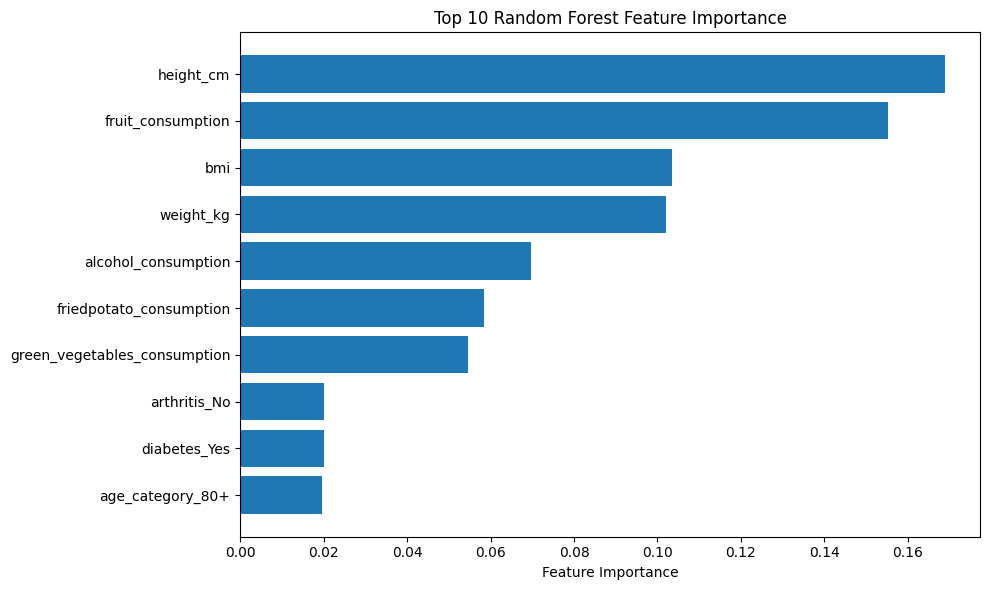

In [37]:
# Plot the feature importance
y_pos = range(len(top_importance_df))
plt.figure(figsize=(10, 6))
plt.barh(y_pos, top_importance_df['Importance'])
plt.yticks(y_pos, top_importance_df['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top {} Random Forest Feature Importance'.format(top_n))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


While the feature importance analysis provides valuable insights, several important considerations highlight the need for further investigation:

1. Correlation vs. Causation: Feature importance does not establish causation. While height, fruit consumption, and BMI may be important predictors, they may not be the direct causes of CVD.

2. Domain Expertise: Medical and domain experts should validate the findings. They can provide insights into the biological and clinical relevance of these features and their relationships with CVD.

3. Data Quality: The results are based on the quality and representativeness of the dataset.



**OPTIMISATION 1**

In [38]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)


Distribution of hyperparameters was defined in the param_dist dictionary. These hyperparameters include:

n_estimators: The number of trees in the forest (100, 200, or 300).

max_depth: The maximum depth of each tree (None, 10, 20, or 30).

min_samples_split: The minimum number of samples required to split a node (2, 5, or 10).

min_samples_leaf: The minimum number of samples required to be a leaf node (1, 2, or 4).

max_features: The number of features to consider for the best split ('auto,' 'sqrt,' or 'log2').

In [39]:
# Define a distribution of hyperparameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300],          # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],         # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required to be a leaf node
    'max_features': ['auto', 'sqrt', 'log2'] # Number of features to consider for the best split
}

In [41]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

A RandomizedSearchCV object named random_search to search for the best hyperparameters using random sampling. This process involves:

Using cross-validation (cv=5) to evaluate the model's performance.
Specifying the number of iterations (n_iter=10) to randomly sample hyperparameters.
Setting n_jobs=-1 to utilize all available CPU cores for parallel processing.
Defining scoring='accuracy' as the evaluation metric.
Setting a random state (random_state=42) for reproducibility.

In [42]:
# Create RandomizedSearchCV to search for the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)


In [43]:
# Fit the model to the training data while searching for the best hyperparameters
random_search.fit(X_train_resampled, y_train_resampled)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy', verbose=2)

The final Random Forest model (final_rf_classifier) using the best hyperparameters obtained from the search was created.



In [44]:
# Get the best hyperparameters
best_params = random_search.best_params_

In [45]:
# Use the best hyperparameters to create the final Random Forest model
final_rf_classifier = RandomForestClassifier(random_state=42, **best_params)


In [46]:
# Fit the final model to the training data
final_rf_classifier.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', min_samples_leaf=2, random_state=42)

In [47]:
# Predicting on the test data using the final model
y_pred = final_rf_classifier.predict(X_test)

In [48]:
# Evaluate the final model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

The accuracy of the optimized Random Forest Classifier is approximately 92.64%. This indicates that the model correctly predicted the class labels for about 92.64% of the samples in the test dataset.

Classification Report:

The classification report provides additional performance metrics beyond accuracy:

Precision measures the proportion of true positive predictions out of all positive predictions. For class 0, precision is 0.93, and for class 1, it's 0.92. This indicates that the model has a high precision for both classes, meaning it makes relatively few false positive errors.

Recall (or sensitivity) measures the proportion of true positive predictions out of all actual positives. For class 0, recall is 0.97, and for class 1, it's 0.83. This suggests that the model is better at identifying true negatives (class 0) than true positives (class 1).

F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall. For class 0, the F1-score is 0.95, and for class 1, it's 0.87. A high F1-score indicates a good balance between precision and recall.

Support indicates the number of samples in each class.

Macro Avg and Weighted Avg:

The macro average (macro avg) computes the average of metrics across both classes without considering class imbalance. In this case, the macro avg F1-score is approximately 0.91.
The weighted average (weighted avg) computes the average of metrics, weighted by the number of samples in each class. This accounts for class imbalance, and the weighted avg F1-score is also approximately 0.93.

In [49]:
# Print the results
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("Classification Report:\n", class_report)

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None}
Accuracy: 0.9264262756126959
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     13913
           1       0.92      0.83      0.87      5999

    accuracy                           0.93     19912
   macro avg       0.92      0.90      0.91     19912
weighted avg       0.93      0.93      0.93     19912



Comparison with the Initial Random Forest Model:

The optimized Random Forest model shows an improvement in accuracy (92.64%) compared to the initial model (92.84%). While the difference in accuracy is relatively small, optimization is still beneficial.

Precision for class 0 is similar in both models, but precision for class 1 improved from 0.82 (initial model) to 0.92 (optimized model). This indicates a reduction in false positive errors for class 1 in the optimized model.

Recall for class 1 decreased slightly from 0.84 (initial model) to 0.83 (optimized model). This means that the optimized model is slightly less effective at identifying true positives for class 1, but the increase in precision suggests a trade-off that may be acceptable depending on the specific application.

The F1-score for class 1 increased from 0.83 (initial model) to 0.87 (optimized model), indicating better overall performance for class 1.

The macro avg F1-score remained fairly consistent, while the weighted avg F1-score increased slightly from 0.93 (initial model) to 0.93 (optimized model).

Overall, the optimized Random Forest model demonstrates improved precision, comparable recall, and a slightly better F1-score for class 1, which suggests that it is better at minimizing false positive errors and achieving a balance between precision and recall for both classes. While the accuracy difference is small, these changes can have practical implications depending on the specific use case and the importance of minimizing different types of errors.

# Model 5: Neural Network